In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import time

In [4]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
def set_seed(x): 
    #random.seed(x)
    np.random.seed(x)
    T.manual_seed(x)
    T.backends.cudnn.deterministic = True
    T.backends.cudnn.benchmark = False
    if T.cuda.is_available(): 
        T.cuda.manual_seed_all(x)

In [6]:
seed= 42
set_seed(seed)

# Broadcasting

In [7]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)
        self.v = nn.Linear(fc2_dims, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = self.pi(x)
        v = self.v(x)

        return (pi, v)


In [8]:
class Agent():
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, 
                 gamma=0.99):
        self.gamma = gamma
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.actor_critic = ActorCriticNetwork(lr, input_dims, n_actions, 
                                               fc1_dims, fc2_dims)
        self.log_prob = None

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor_critic.device)
        probabilities, _ = self.actor_critic.forward(state)
        probabilities = F.softmax(probabilities, dim=1)
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()

    def learn(self, state, reward, state_, done):
        self.actor_critic.optimizer.zero_grad()

        state = T.tensor([state], dtype=T.float).to(self.actor_critic.device)
        state_ = T.tensor([state_], dtype=T.float).to(self.actor_critic.device)
        reward = T.tensor(reward, dtype=T.float).to(self.actor_critic.device)

        _, critic_value = self.actor_critic.forward(state)
        _, critic_value_ = self.actor_critic.forward(state_)

        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value

        actor_loss = -self.log_prob*delta
        critic_loss = delta**2

        (actor_loss + critic_loss).backward()
        self.actor_critic.optimizer.step()

In [9]:
env = gym.make('LunarLander-v2')
env.seed(seed)
n_games = 3001
agent = Agent(gamma=0.99, lr=5e-6, input_dims=[8], n_actions=4,
                  fc1_dims=2048, fc2_dims=1536)
episode_time=[]
scores = []
for i in range(n_games):
    toc= time.time()
    done = False
    observation = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.learn(observation, reward, observation_, done)
        observation = observation_
    scores.append(score)
    tic=time.time()
    episode_time.append(tic-toc)
    intvl=250
    if i % intvl == 0:
        avg_score = np.mean(scores[-intvl:])
        avg_time = np.mean(episode_time[-intvl:])
        print('Episode ', i, 'Score %.2f' % score, 'Average score %.2f' % avg_score, 'Average episode time %.2f' % avg_time, '(sec)')
env.close()

Episode  0 Score -173.11 Average score -173.11 Average episode time 4.60 (sec)
Episode  250 Score -296.83 Average score -181.39 Average episode time 9.26 (sec)
Episode  500 Score -264.73 Average score -79.00 Average episode time 23.51 (sec)
Episode  750 Score 205.23 Average score -46.23 Average episode time 29.77 (sec)
Episode  1000 Score 92.20 Average score 6.93 Average episode time 29.87 (sec)
Episode  1250 Score 107.38 Average score 56.26 Average episode time 34.70 (sec)
Episode  1500 Score 214.86 Average score 85.34 Average episode time 30.61 (sec)
Episode  1750 Score 196.13 Average score 136.35 Average episode time 25.10 (sec)
Episode  2000 Score 14.83 Average score 134.27 Average episode time 26.17 (sec)
Episode  2250 Score 273.40 Average score 140.36 Average episode time 26.59 (sec)
Episode  2500 Score 18.21 Average score 123.30 Average episode time 29.95 (sec)
Episode  2750 Score 265.23 Average score 129.48 Average episode time 28.77 (sec)
Episode  3000 Score 267.93 Average sco

In [17]:
model=agent.actor_critic.state_dict()
filepath='Models/ActorCritic.pth'

In [18]:
T.save(model, filepath)

In [62]:
tm=(np.array(episode_time).sum()/(60*60))
print( 'Time to complete %.2f' % tm, '(hrs)')

Time to complete 22.68 (hrs)


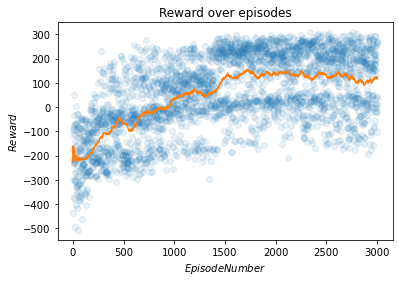

In [11]:
x = [i+1 for i in range(len(scores))]
running_avg = np.zeros(len(scores))
for i in range(len(running_avg)):
    running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])

plt.plot(x, scores, 'o', alpha=0.1)
plt.plot(x, running_avg)
plt.title('Reward over episodes')
plt.ylabel(r'$Reward$')
plt.xlabel(r'$Episode Number$')
plt.show()

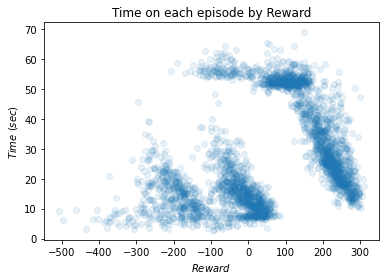

In [12]:
x = scores
y=episode_time
plt.plot(x, y, 'o', alpha=0.1)

plt.title('Time on each episode by Reward')
plt.ylabel(r'$Time \ (sec)$')
plt.xlabel(r'$Reward$')
plt.show()

# Fin

In [13]:
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Wednesday September 29, 2021 at 11:53
